# Quantum process tomography

In quantum computing process tomography is mostly used to experimentally measure the quality of gates. The quality is how close the experimental implementation of the gate is to the ideal gate.

### Classical "process" tomography 

On a single bit there are two processes (or gates or operations) one can perform, `identity`  and `not`, which we will denote as $I$ and $X$. The `identity` operation behaves as
$I 0 = 0$ and $I 1 = 1$ while `not` behaves as $X 0 = 1$ and $X 1 = 0$. To do classical process tomography we simply need to input a $0$ and $1$ into the circuit implementing a particular operation and compare the output to what we ideally expect. 

The operation of a faulty classical gate can be captured by the probability of all output strings $j$ given all possible input strings $i$, i.e. $\Pr({\rm output\ } j| {\rm input\ }i)$. It is convenient to collect these probabilities into a matrix which is called a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). For a gate $G$ on single bit $ i,j \in \{0, 1 \}$ it is

$$
C(G) =
\begin{pmatrix}
\Pr(0|0) &  \Pr(0|1)\\
\Pr(1|0) &  \Pr(1|1)
\end{pmatrix}.
$$
The ideal confusion matrix for `identity` is $ \Pr( j | i ) = \delta_{i,j} $ while for `not` it is  $ \Pr( j | i ) = 1 -\delta_{i,j} $.

### Quantum process tomography of a single qubit

To motivate the additional complexity of quantum process tomography over classical process tomography consider the following.

We would like to distinguish the following quantum processes
$$
H = \frac{1}{\sqrt{2}}
\begin{pmatrix}
1 &  1\\
1 &  -1
\end{pmatrix}.
$$
and 
$$
R_Y(\pi/2) = \exp[-i (\pi/2) Y/2].
$$


To distingiush these processes we estimate the confusion matrices in the standard basis (the Z basis). After many trials the probabilities obey 

$$
\Pr(j|G, \rho_i) = {\rm Tr}[G\rho_i G^\dagger \Pi_j],
$$ 

where $\Pi_j= |j\rangle \langle j|$ is a measurement operator with $j\in\{ 0,1 \}$, $\rho_i=|i\rangle \langle i|$ is the input state with $i\in\{ 0,1 \}$,  and $G$ is the quantum process ie $H$ or $R_Y$. 

Using the expression for $\Pr(j|G, \rho_i)$ we can construct the confusion matrices for each process. Unfortunately the two confusion matrices are identical
$$
C(H)= C\big(R_Y(\pi/2)\big) = \frac 1 2
\begin{pmatrix}
1 &  1\\
1 &  1
\end{pmatrix}.
$$
However, if we input the states $\rho_+=|+\rangle\langle +|$ and $\rho_-=|-\rangle\langle -|$ the confusion matrices become 
$$
C(H) = \frac 1 2
\begin{pmatrix}
1 & 0\\
0 &  1
\end{pmatrix} 
\quad {\rm and} \quad
C\big(R_Y(\pi/2)\big) = \frac 1 2
\begin{pmatrix}
1 &  1\\
1 &  1
\end{pmatrix}. 
$$
Instead of using a different input state we could have measured in different bases. A rough way to think about quantum process tomography is you need to input a tomographically complete set of input states and measure the confusion matrix of those states in a tomographically complete basis.

A *tomographically complete* set of operators is an operator basis on the Hilbert space of the system. For a single qubit this is the Pauli operators $\{ I, X, Y, Z \}$.


### Quantum process tomography in general   

The above analogy gets further stretched when we consider imperfect gates (non unitary processes). Indeed understanding quantum process tomography is beyond the scope of this notebook.


Quantum process tomography involves
 - preparing a state
 - executing a process (the thing you are trying to estimate)
 - measuring in a basis
 
 <figure>
  <img src="figs/process-tomo.png" alt="Drawing" style="width: 460px;"/>
  <figcaption>Figure 1. For process tomography, rotations must be prepended and appended to fully resolve the action of V on arbitrary initial states.</figcaption>
</figure>
 
 
The process is kept fixed, while the experimental settings (the preparation and measurement) are varied using pre and post rotations, see Figure 1. To estimate a quantum process matrix on $n$ qubits requires estimating $D^4-D^2$ parameters where $D=2^n$ is the dimension of the Hilbert space.



Programmatically, (prep, measure) tuples are varied over every `itertools.product` combination of chosen input states and measurement operators.

There are two choices of tomographically complete input states, *SIC* states and *Pauli* states.

The SIC states are the states corresponding to the directions of a [SIC POVM](https://en.wikipedia.org/wiki/SIC-POVM). In this case there are only four states, but we still have to measure in the Pauli basis. The scaling of the number of experiments with respect to number of qubits is therefore $4^n 3^n$.

The alternative is to use $\pm$ eigenstates of the Pauli operators as our tomographically complete input states. In this case there are six input states, and we still have to measure in the Pauli basis. The scaling of the number of experiments with respect to number of qubits is therefore $6^n 3^n$.

**More information** 


When thinking about process tomography it is necessary to understand superoperators. For more information see [superoperator_representations.md](../.././forest-benchmarking/docs/superoperator_representations.md) and the [superoperator_tools ipython notebook](superoperator_tools.ipynb).

Also see the following references:

[CWPHD] *Initialization and characterization of open quantum systems*  
Christopher Wood,  
Chapter 3, PhD Thesis, University of Waterloo (2015)  
http://hdl.handle.net/10012/9557  


[IGST]  *Introduction to Quantum Gate Set Tomography*  
Daniel Greenbaum,  
arXiv:1509.02921 (2015)    
https://arxiv.org/abs/1509.02921  


[PBT]  *Practical Bayesian Tomography*  
Christopher Granade et al.  
New J. Phys. 18, 033024 (2016)  
https://dx.doi.org/10.1088/1367-2630/18/3/033024  
https://arxiv.org/abs/1509.03770


[SCQPT] Self-Consistent Quantum Process Tomography  
Seth T. Merkel et al.  
Phys. Rev. A 87, 062119 (2013)  
https://dx.doi.org/10.1103/PhysRevA.87.062119  
https://arxiv.org/abs/1211.0322  

## Quantum process tomography in `forest.benchmarking`

Before reading this section make sure you are familiar with the [state tomography ipython notebook](tomography_state.ipynb).

The basic workflow is:

1. Prepare a process that you wish to estiamte by specifying a pyQuil program.
2. Construct a list of input and output observables that are needed to estimate the state; we collect this into an object called an `ObservablesExperiment`.
3. Acquire the data by running the program on a QVM or QPU.
4. Apply an estimator to the data to obtain an estimate of the process.
5. Compare the estimated state to the true state by a distance measure or visualization.


Below we break these steps down into all their ghastly glory. 

## Step 1. Construct a process

We choose an $RX(\pi/2)$ which is represented as a pyQuil `Program`.

The true process is 

$$
RX(\pi) 
=  \exp[-i \pi X /2] 
= \begin{pmatrix}
0 &  -i\\
-i &  0
\end{pmatrix}.
$$
which is $X$ upto an irrelevant global phase.

In [1]:
#some imports
import numpy as np
from pyquil import Program, get_qc
from pyquil.gates import *
qc = get_qc('2q-qvm')

In [2]:
# numerical representation of the true process

from pyquil.gate_matrices import RX as RX_matrix
from forest.benchmarking.operator_tools import kraus2choi

kraus_true = RX_matrix(np.pi)
print('The Kraus representation is:\n', np.round(kraus_true, 2),'\n')

choi_true = kraus2choi(kraus_true)
print('The Choi representation is:\n', np.real_if_close(np.round(choi_true, 2)))

from pyquil.gate_matrices import X as X_matrix
choi_x_gate = kraus2choi(X_matrix)
print('\n The X gate choi matrix is:\n', np.real_if_close(np.round(choi_x_gate)))

The Kraus representation is:
 [[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]] 

The Choi representation is:
 [[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]]

 The X gate choi matrix is:
 [[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]]


In [3]:
# construct the process program

qubits = [0]
process = Program(RX(np.pi, qubits[0]))
print(process)

RX(pi) 0



## Step 2. Construct a `ObservablesExperiment` for process tomography

See this [notebook](observable_estimation.ipynb) for more on `ObservablesExperiment` and for a demonstration of grouping compatible experiment settings to reduce the total number of data acquisition runs needed.

Note: An `I` measurement, though possible, is 'trivial' in the sense that we know the outcome is always 1; therefore, we omit the settings where I is 'measured'. Our estimators add in the contribution of this I term automatically, so be mindful of this if you are making your own settings. 

In [4]:
from forest.benchmarking.tomography import generate_process_tomography_experiment

experiment = generate_process_tomography_experiment(process, qubits)
print(experiment)

RX(pi) 0
0: X+_0→(1+0j)*X0
1: X+_0→(1+0j)*Y0
2: X+_0→(1+0j)*Z0
3: X-_0→(1+0j)*X0
4: X-_0→(1+0j)*Y0
5: X-_0→(1+0j)*Z0
6: Y+_0→(1+0j)*X0
7: Y+_0→(1+0j)*Y0
8: Y+_0→(1+0j)*Z0
9: Y-_0→(1+0j)*X0
10: Y-_0→(1+0j)*Y0
11: Y-_0→(1+0j)*Z0
12: Z+_0→(1+0j)*X0
13: Z+_0→(1+0j)*Y0
14: Z+_0→(1+0j)*Z0
15: Z-_0→(1+0j)*X0
16: Z-_0→(1+0j)*Y0
17: Z-_0→(1+0j)*Z0


## Step 3. Acquire the data

PyQuil will run the tomography programs.

We will use the QVM but at this point you can use a QPU.

In [5]:
from forest.benchmarking.observable_estimation import estimate_observables
results = list(estimate_observables(qc, experiment))
results

[ExperimentResult[X+_0→(1+0j)*X0: 1.0 +- 0.0],
 ExperimentResult[X+_0→(1+0j)*Y0: -0.048 +- 0.04466981083461179],
 ExperimentResult[X+_0→(1+0j)*Z0: 0.0 +- 0.044721359549995794],
 ExperimentResult[X-_0→(1+0j)*X0: -1.0 +- 0.0],
 ExperimentResult[X-_0→(1+0j)*Y0: 0.048 +- 0.04466981083461179],
 ExperimentResult[X-_0→(1+0j)*Z0: 0.004 +- 0.04472100177768829],
 ExperimentResult[Y+_0→(1+0j)*X0: -0.084 +- 0.04456330328869259],
 ExperimentResult[Y+_0→(1+0j)*Y0: -1.0 +- 0.0],
 ExperimentResult[Y+_0→(1+0j)*Z0: 0.028 +- 0.04470382533967312],
 ExperimentResult[Y-_0→(1+0j)*X0: -0.036 +- 0.04469237071357929],
 ExperimentResult[Y-_0→(1+0j)*Y0: 1.0 +- 0.0],
 ExperimentResult[Y-_0→(1+0j)*Z0: -0.024 +- 0.04470847794322683],
 ExperimentResult[Z+_0→(1+0j)*X0: 0.028 +- 0.04470382533967311],
 ExperimentResult[Z+_0→(1+0j)*Y0: 0.064 +- 0.044629676225578875],
 ExperimentResult[Z+_0→(1+0j)*Z0: -1.0 +- 0.0],
 ExperimentResult[Z-_0→(1+0j)*X0: 0.024 +- 0.04470847794322683],
 ExperimentResult[Z-_0→(1+0j)*Y0: 0.016 +- 

## Step 4. Apply some estimators to the data "do tomography"

### Linear Inversion Estimate

Sometimes the Linear Inversion Estimates can be unphysical. But we can use `proj_choi_to_physical` to force it to be physical.

In [6]:
from forest.benchmarking.tomography import linear_inv_process_estimate
from forest.benchmarking.operator_tools import proj_choi_to_physical

print('Linear inversion estimate:\n')
choi_lin_inv_est = linear_inv_process_estimate(results, qubits)
print(np.real_if_close(np.round(choi_lin_inv_est, 2)))

print('\n Project the above estimate to a physical estimate:\n')
choi_lin_inv_proj_phys_est = proj_choi_to_physical(choi_lin_inv_est)
print(np.real_if_close(np.round(choi_lin_inv_proj_phys_est, 2)))

Linear inversion estimate:

[[ 0.  -0.j   -0.  -0.02j -0.  +0.01j -0.  +0.01j]
 [-0.  +0.02j  1.  -0.j    1.  -0.04j  0.  -0.01j]
 [-0.  -0.01j  1.  +0.04j  1.  +0.j   -0.01+0.01j]
 [-0.  -0.01j  0.  +0.01j -0.01-0.01j -0.  +0.j  ]]

 Project the above estimate to a physical estimate:

[[ 0.01+0.j   -0.  -0.01j  0.  +0.j   -0.  +0.j  ]
 [-0.  +0.01j  0.99+0.j    0.99-0.04j -0.  -0.j  ]
 [ 0.  -0.j    0.99+0.04j  1.  +0.j   -0.  +0.j  ]
 [-0.  -0.j   -0.  +0.j   -0.  -0.j    0.  -0.j  ]]


### Maximum likelihood  Estimate 

Using the [PGDB algorithm](https://arxiv.org/abs/1803.10062).

In [7]:
from forest.benchmarking.tomography import pgdb_process_estimate

choi_mle_est = pgdb_process_estimate(results, qubits)
np.real_if_close(np.round(choi_mle_est, 2))

array([[-0.  +0.j  , -0.  +0.j  , -0.  +0.j  ,  0.  +0.j  ],
       [-0.  -0.j  ,  1.  +0.j  ,  1.01-0.02j,  0.  -0.j  ],
       [-0.  -0.j  ,  1.01+0.02j,  1.  -0.j  ,  0.  -0.j  ],
       [ 0.  -0.j  ,  0.  +0.j  ,  0.  +0.j  , -0.  +0.j  ]])

## Step 5. Compare estimated process to the true process

In [8]:
choi_estimates = {
    'True Process': choi_true,
    'Linear Inv': choi_lin_inv_est,
    'ProjLinInv': choi_lin_inv_proj_phys_est,
    'Plain MLE': choi_mle_est
    }

**Process fidelity**

In [9]:
from forest.benchmarking.operator_tools import choi2pauli_liouville
from forest.benchmarking.distance_measures import process_fidelity

# process_fidelity uses  pauli liouville rep
pl_true = choi2pauli_liouville(choi_true)

for key, choi_e in choi_estimates.items():
    pl_e = choi2pauli_liouville(choi_e)
    fid = np.round(process_fidelity(pl_true, pl_e), 3)
    print(f"Fidelity(True Process, {key}) = {fid}")

Fidelity(True Process, True Process) = 1.0
Fidelity(True Process, Linear Inv) = 1.0
Fidelity(True Process, ProjLinInv) = 0.996
Fidelity(True Process, Plain MLE) = 1.003


**Diamond norm distance**

In [10]:
from forest.benchmarking.distance_measures import diamond_norm_distance

# diamond_norm_distance takes the choi rep
for key, choi_e in choi_estimates.items():
    fid = np.round(diamond_norm_distance(choi_true, choi_e), 3)
    print(f"Diamond_norm_dist(True Process, {key}) = {fid}")

Diamond_norm_dist(True Process, True Process) = -0.0
Diamond_norm_dist(True Process, Linear Inv) = 0.068
Diamond_norm_dist(True Process, ProjLinInv) = 0.045
Diamond_norm_dist(True Process, Plain MLE) = 0.028


## Plot Pauli Transfer Matrix of Estimate

In [11]:
import matplotlib.pyplot as plt
from forest.benchmarking.plotting.state_process import plot_pauli_transfer_matrix

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(choi_true)), ax1, title='Ideal')
plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(choi_lin_inv_est)), ax2, title='Lin Inv Estimate')
plot_pauli_transfer_matrix(np.real(choi2pauli_liouville(choi_mle_est)), ax3, title='MLE Estimate')
plt.tight_layout()


## Two qubit example - CNOT

In [12]:
# the process
qubits = [0, 1]
process = Program(CNOT(qubits[0], qubits[1]))

# the experiment object
experiment = generate_process_tomography_experiment(process, qubits, in_basis='sic')
print(experiment)

CNOT 0 1
0: SIC0_0 * SIC0_1→(1+0j)*X1
1: SIC0_0 * SIC0_1→(1+0j)*Y1
2: SIC0_0 * SIC0_1→(1+0j)*Z1
3: SIC0_0 * SIC0_1→(1+0j)*X0
4: SIC0_0 * SIC0_1→(1+0j)*X0X1
5: SIC0_0 * SIC0_1→(1+0j)*X0Y1
6: SIC0_0 * SIC0_1→(1+0j)*X0Z1
7: SIC0_0 * SIC0_1→(1+0j)*Y0
8: SIC0_0 * SIC0_1→(1+0j)*Y0X1
9: SIC0_0 * SIC0_1→(1+0j)*Y0Y1
... 220 not shown ...
... use e.settings_string() for all ...
230: SIC3_0 * SIC3_1→(1+0j)*X0Y1
231: SIC3_0 * SIC3_1→(1+0j)*X0Z1
232: SIC3_0 * SIC3_1→(1+0j)*Y0
233: SIC3_0 * SIC3_1→(1+0j)*Y0X1
234: SIC3_0 * SIC3_1→(1+0j)*Y0Y1
235: SIC3_0 * SIC3_1→(1+0j)*Y0Z1
236: SIC3_0 * SIC3_1→(1+0j)*Z0
237: SIC3_0 * SIC3_1→(1+0j)*Z0X1
238: SIC3_0 * SIC3_1→(1+0j)*Z0Y1
239: SIC3_0 * SIC3_1→(1+0j)*Z0Z1


Here we are going to speed things up by grouping compatible settings to be estimated from the same set of data. 
See this [notebook](observable_estimation.ipynb) for more information.

In [13]:
from forest.benchmarking.observable_estimation import group_settings
results = list(estimate_observables(qc, group_settings(experiment)))
results[:10]

[ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X1: -0.072 +- 0.044605291165959224],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0: 0.02 +- 0.04471241438347967],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0X1: 0.004 +- 0.04472100177768829],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y1: -0.012 +- 0.04471813949618208],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0Y1: -0.036 +- 0.044692370713579295],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Z1: 1.0 +- 0.0],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*X0Z1: 0.056 +- 0.044651181395344956],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y0: -0.028 +- 0.04470382533967311],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y0X1: 0.06 +- 0.04464078852350168],
 ExperimentResult[SIC0_0 * SIC0_1→(1+0j)*Y0Y1: 0.0 +- 0.044721359549995794]]

In [14]:
def _print_big_matrix(mat):
    for row in mat:
        for elem in row:
            elem = np.real_if_close(np.round(elem, 3), tol=1e-1)
            if not np.isclose(elem, 0., atol=1e-2):
                print(f'{elem:.1f}', end=' ')
            else:
                print(' . ', end=' ')
        print()

In [15]:
process_choi_est = pgdb_process_estimate(results, qubits)
_print_big_matrix(process_choi_est)

1.0  .   .   .   .  1.0  .   .  0.0 0.0 -0.0 1.0  .  0.0 1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .  -0.0  .   .   .   .  
 .   .   .   .   .  0.0  .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .  0.0 1.0  .   .   .  0.0 -0.0 1.0 -0.0  .  1.0 0.0 
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
0.0  .   .   .   .   .   .   .  0.0  .   .  0.0  .  0.0  .   .  
0.0  .   .   .   .  0.0  .   .   .   .   .  0.0  .   .  0.0  .  
-0.0  .   .   .   .  -0.0  .   .   .   .   .  -0.0  .   .  -0.0  .  
1.0  .   .  -0.0  .  1.0  .   .  0.0 0.0 -0.0 1.0 -0.0 0.0 1.0 0.0 
 .   .   .   .   .  -0.0  .   .   .   .   .  -0.0  .   .  -0.0  .  
0.0  .   .   .   .   .   .   .  0.0  .   .  0.0  .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .  0.0 -0.0 1.0 -0.0  .  1.0 0.0 
 .   .   

In [16]:
from pyquil.gate_matrices import CNOT as CNOT_matrix
process_choi_ideal = kraus2choi(CNOT_matrix)
_print_big_matrix(process_choi_ideal)

1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
 .   .   .   .   .   .   .   .   .   .   .   .   .   .   .   .  
1.0  .   .   .   .  1.0  .   .   .   .   .  1.0  .   .  1.0  .  
 .   .   .   .   .   .   

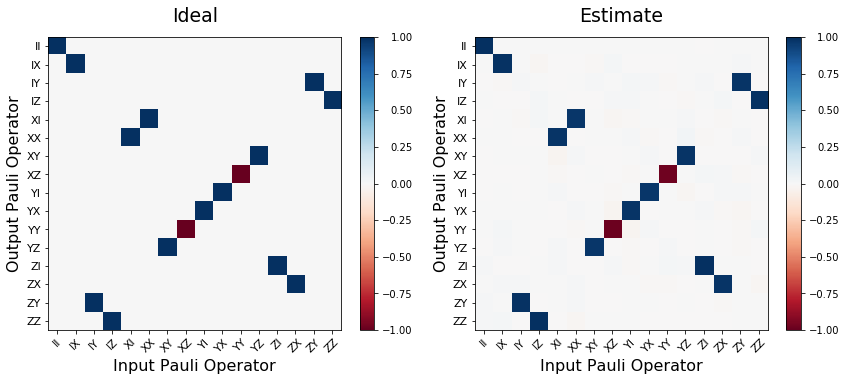

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ideal_ptm = choi2pauli_liouville(process_choi_ideal)
est_ptm = choi2pauli_liouville(process_choi_est)
plot_pauli_transfer_matrix(ideal_ptm, ax1, title='Ideal')
plot_pauli_transfer_matrix(est_ptm, ax2, title='Estimate')
plt.tight_layout()

## Advanced topics: parallel process estimation

The `ObservablesExperiment` [framework](observable_estimation.ipynb) allows for easy parallelization of experiments that operate on disjoint sets of qubits. Below we will demonstrate the simple example of tomographing two separate bit flip processes `Program(X(0))` and `Program(X(1))`. To run each experiment in serial would require $n_1 + n_2 = 2n$ experimental runs ($n_1 = n_2 = n$ in this case), but when we run a 'parallel' experiment we need only $n$ runs. 

Note that the parallel experiment is not the same as doing tomography on the program `Program(X(0), X(1))` because in the later case we need to do more data acquisition runs on the qc and we get more information back (we tomographize a 2 qubit process instead of two 1 qubit processes). The `ExperimentSetting`s for that experiment are a superset of the prallel settings. We also cannot directly compare a parallel experiment with two serial experiments, because in a parallel experiment 'cross-talk' and other multi-qubit effects can impact the overall process; that is, the physics of 'parallel' experiments cannot in general be neatly factored into two serial experiments. 

See the linked [notebook](observable_estimation.ipynb) for more explanation and words of caution.

In [18]:
from forest.benchmarking.observable_estimation import ObservablesExperiment, merge_disjoint_experiments

disjoint_sets_of_qubits = [(0,),(1,)]
programs = [Program(X(*q)) for q in disjoint_sets_of_qubits]

expts_to_parallelize = []
for qubits, program in zip(disjoint_sets_of_qubits, programs):
    expt = generate_process_tomography_experiment(program, qubits)
    # group the settings for fair comparison later 
    expts_to_parallelize.append(group_settings(expt))

# get a merged experiment and group the settings for parallel data acquisition
parallel_expt = group_settings(merge_disjoint_experiments(expts_to_parallelize))

print(f'Original number of runs: {sum(len(expt) for expt in expts_to_parallelize)}')
print(f'Parallelized number of runs: {len(parallel_expt)}')
print(parallel_expt)

Original number of runs: 36
Parallelized number of runs: 18
X 0; X 1
0: X+_0→(1+0j)*X0, X+_1→(1+0j)*X1
1: X+_0→(1+0j)*Y0, X+_1→(1+0j)*Y1
2: X+_0→(1+0j)*Z0, X+_1→(1+0j)*Z1
3: X-_0→(1+0j)*X0, X-_1→(1+0j)*X1
4: X-_0→(1+0j)*Y0, X-_1→(1+0j)*Y1
5: X-_0→(1+0j)*Z0, X-_1→(1+0j)*Z1
6: Y+_0→(1+0j)*X0, Y+_1→(1+0j)*X1
7: Y+_0→(1+0j)*Y0, Y+_1→(1+0j)*Y1
8: Y+_0→(1+0j)*Z0, Y+_1→(1+0j)*Z1
9: Y-_0→(1+0j)*X0, Y-_1→(1+0j)*X1
10: Y-_0→(1+0j)*Y0, Y-_1→(1+0j)*Y1
11: Y-_0→(1+0j)*Z0, Y-_1→(1+0j)*Z1
12: Z+_0→(1+0j)*X0, Z+_1→(1+0j)*X1
13: Z+_0→(1+0j)*Y0, Z+_1→(1+0j)*Y1
14: Z+_0→(1+0j)*Z0, Z+_1→(1+0j)*Z1
15: Z-_0→(1+0j)*X0, Z-_1→(1+0j)*X1
16: Z-_0→(1+0j)*Y0, Z-_1→(1+0j)*Y1
17: Z-_0→(1+0j)*Z0, Z-_1→(1+0j)*Z1


Collect the data. Separate the results by qubit to get back estimates of each process.

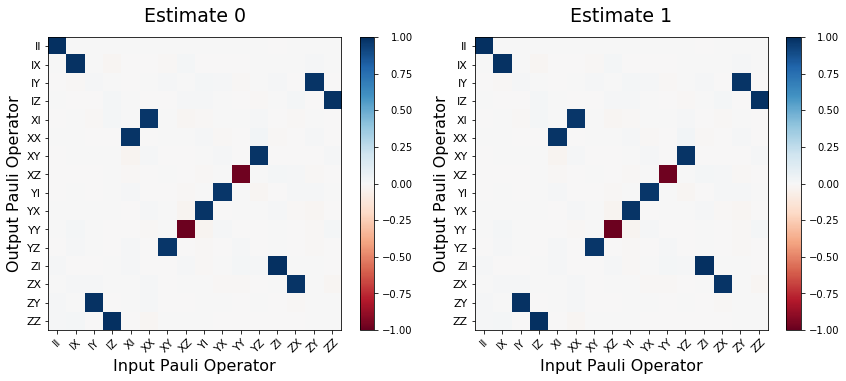

In [19]:
from forest.benchmarking.observable_estimation import get_results_by_qubit_groups

parallel_results = estimate_observables(qc, parallel_expt)
process_estimates = []

individual_results = get_results_by_qubit_groups(parallel_results, disjoint_sets_of_qubits)
for q in disjoint_sets_of_qubits:
    estimate = pgdb_process_estimate(individual_results[q], q)
    process_estimates.append(estimate)

fig, axes = plt.subplots(1, len(process_estimates), figsize=(12,5))
for idx, est in enumerate(process_estimates):
    plot_pauli_transfer_matrix(choi2pauli_liouville(process_choi_est), axes[idx], title=f'Estimate {idx}')

plt.tight_layout()
